In [1]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from S2P import ShortSeq2PointDisaggregator
import time
import metrics

In [2]:
print("========== OPEN DATASETS ============")
train_house02 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train_house03 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train_house02.set_window(end="5-2-2011")
train_house03.set_window(end="28-4-2011")

val = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
val.set_window(start="16-5-2011")

test = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
test.set_window(end="5-3-2011")

train_building = [2,3]
val_building = 1
test_building = 1
sample_period = 3
meter_key = 'fridge'

train_mains = []
train_mains.append(train_house02.buildings[train_building[0]].elec.mains().all_meters()[1])
train_mains.append(train_house03.buildings[train_building[1]].elec.mains().all_meters()[0])
# train_mains.append(train.buildings[train_building[2]].elec.mains().all_meters()[0])

train_meters = []
train_meters.append(train_house02.buildings[train_building[0]].elec.submeters()[meter_key])
train_meters.append(train_house03.buildings[train_building[1]].elec.submeters()[meter_key])


test_mains = test.buildings[test_building].elec.mains().all_meters()[0]
test_meters = test.buildings[test_building].elec.submeters()[meter_key]

val_mains = val.buildings[val_building].elec.mains().all_meters()[0]
val_meters = val.buildings[val_building].elec.submeters()[meter_key]

S2P = ShortSeq2PointDisaggregator(window_size=300)

========== OPEN DATASETS ============
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 300, 30)           330       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 30)           7230      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 300, 40)           7240      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 300, 50)           10050     
_________________________________________________________________
dropout (Dropout)            (None, 300, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 300, 50)           12550     
_________________________________________________________________
dropout_1 (Dropout

In [3]:
start = time.time()
print("========== TRAIN ============")

history01 = S2P.train(train_mains[0], train_meters[0], epochs=10)
history02 = S2P.train(train_mains[1], train_meters[1], epochs=10)

S2P.export_model("model_CNN_win300.h5")

end = time.time()
print("Train =", end-start, "seconds.")

========== TRAIN ============
(312688, 300, 1)
(312688,)
356.2344
84.37994
219.84592
61.480576
128
Epoch 1/10
1955/1955 [==============================] - 42s 17ms/step - loss: 0.1450 - val_loss: 0.1114
Epoch 2/10
1955/1955 [==============================] - 46s 24ms/step - loss: 0.0710 - val_loss: 0.0867
Epoch 3/10
1955/1955 [==============================] - 68s 35ms/step - loss: 0.0591 - val_loss: 0.0926
Epoch 4/10
1955/1955 [==============================] - 65s 33ms/step - loss: 0.0526 - val_loss: 0.0970
Epoch 5/10
1955/1955 [==============================] - 87s 45ms/step - loss: 0.0486 - val_loss: 0.0672
Epoch 6/10
1955/1955 [==============================] - 70s 36ms/step - loss: 0.0494 - val_loss: 0.0709
Epoch 7/10
1955/1955 [==============================] - 83s 43ms/step - loss: 0.0444 - val_loss: 0.0654
Epoch 8/10
1955/1955 [==============================] - 75s 39ms/step - loss: 0.0421 - val_loss: 0.0660
Epoch 9/10
1955/1955 [==============================] - 75s 39ms/step

In [4]:
print("========== DISAGGREGATE ============")
disag_filename = 'disag_CNN_win300.h5'
output = HDFDataStore(disag_filename, 'w')
S2P.disaggregate(test_mains, output, train_meters[0], sample_period=sample_period)
output.close()

========== DISAGGREGATE ============
New sensible chunk: 5533
New sensible chunk: 26611
New sensible chunk: 7822
New sensible chunk: 6689
New sensible chunk: 653
New sensible chunk: 29766
New sensible chunk: 13757
New sensible chunk: 32510
New sensible chunk: 34806
New sensible chunk: 20284
New sensible chunk: 64862
New sensible chunk: 525
New sensible chunk: 31931
New sensible chunk: 41483
New sensible chunk: 37554
New sensible chunk: 8252


========== Plot ============


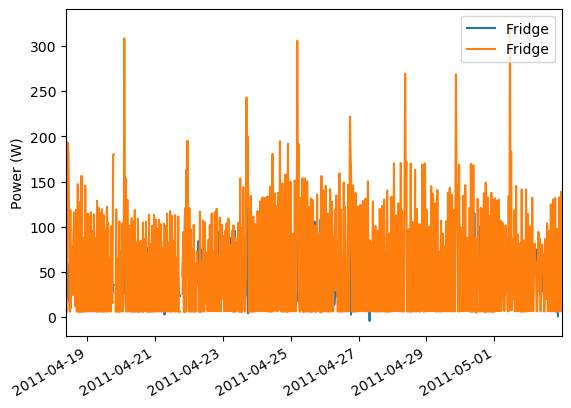

In [5]:
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec

print("========== Plot ============")

predicted = res_elec[meter_key]
ground_truth = test_meters
import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [6]:
good_sections_pre = predicted.good_sections()
good_sections_pre

[TimeFrame(start='2011-04-18 09:37:06-04:00', end='2011-04-18 13:58:45-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:18:03-04:00', end='2011-04-19 12:13:36-04:00', empty=False),
 TimeFrame(start='2011-04-19 12:29:12-04:00', end='2011-04-19 18:45:18-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:35:03-04:00', end='2011-04-20 01:54:30-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:10:33-04:00', end='2011-04-20 02:28:12-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:43:48-04:00', end='2011-04-21 03:17:06-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:32:12-04:00', end='2011-04-21 17:45:03-04:00', empty=False),
 TimeFrame(start='2011-04-21 19:56:24-04:00', end='2011-04-22 22:46:54-04:00', empty=False),
 TimeFrame(start='2011-04-22 23:03:30-04:00', end='2011-04-24 03:48:48-04:00', empty=False),
 TimeFrame(start='2011-04-24 04:07:21-04:00', end='2011-04-24 20:46:33-04:00', empty=False),
 TimeFrame(start='2011-04-24 21:02:12-04:00', end='2011-04-27 02:50:18

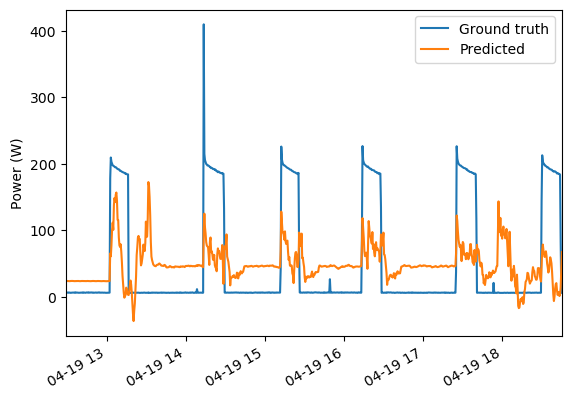

In [7]:
ground_truth.plot(timeframe=good_sections_pre[2])
predicted.plot(timeframe=good_sections_pre[2])
plt.legend(['Ground truth', 'Predicted'])
plt.show()

In [8]:
print(history01)
print(history02)

{'loss': [0.14499519765377045, 0.07099234312772751, 0.0590827651321888, 0.05263066664338112, 0.04864248260855675, 0.049438778311014175, 0.044359106570482254, 0.04210479184985161, 0.04236385226249695, 0.04076412692666054], 'val_loss': [0.11142382770776749, 0.08671242743730545, 0.09262195229530334, 0.0970027968287468, 0.06723035126924515, 0.07085685431957245, 0.06543117016553879, 0.06599132716655731, 0.06626375019550323, 0.08168202638626099]}
{'loss': [0.5573833584785461, 0.4813491702079773, 0.44615715742111206, 0.4282662868499756, 0.4170323610305786, 0.4092521667480469, 0.40574410557746887, 0.3991031348705292, 0.39621496200561523, 0.39293837547302246], 'val_loss': [0.776316225528717, 0.8542307019233704, 0.9834538698196411, 1.0998635292053223, 1.0659546852111816, 1.035315990447998, 1.1601086854934692, 1.0030659437179565, 1.0642449855804443, 1.0899773836135864]}


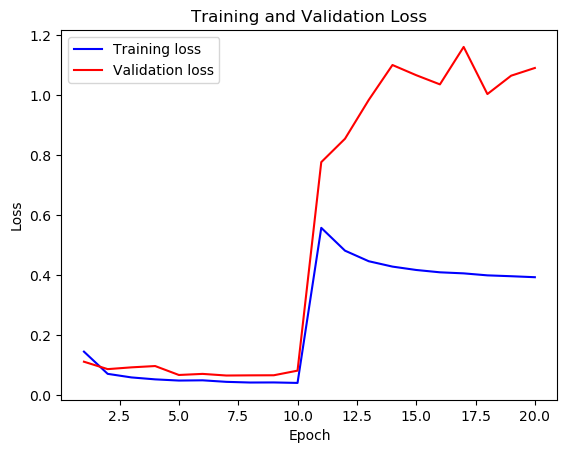

In [10]:
import matplotlib.pyplot as plt

# Combine the history
history = {}
history['loss'] = history01['loss'] + history02['loss']
history['val_loss'] = history01['val_loss'] + history02['val_loss']

# Plot the loss curve
epochs = range(1, len(history['loss']) + 1)
plt.plot(epochs, history['loss'], 'b', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
print("========== RESULTS ============")
result = DataSet('disag_CNN_win300.h5')
res_elec = result.buildings[test_building].elec
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meters)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meters)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meters)))

========== RESULTS ============
============ Recall: 0.8752005477723254
============ Precision: 0.39522849564228874
============ Accuracy: 0.39121647838454215
============ F1 Score: 0.5445470530989345
============ Relative error in total energy: 0.11957441527170892
============ Mean absolute error(in Watts): 61.20581267678172
